# Product level Impact of 3.2 Beer in Minnesota

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Store Data that contains channel info

In [2]:
#load the All stores in Minnesota
All_Stores_Minnesota = pd.read_csv('AllStoresMinnesota.csv')
All_Stores_Minnesota = All_Stores_Minnesota.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Minnesota.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,102798460,CORONA EX 6PK BT,DINING,POLISHED CASUAL,ON,3.0
1,103923027,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
2,104034535,MODELO NEGRA 6PK BT,DINING,CASUAL DINING,ON,3.0
3,105647006,CORONA LT 6PK BT,DINING,CASUAL DINING,ON,8.0
4,101425811,MODELO NEGRA 12PK BT,LIQUOR,LIQUOR SUPER STORE,OFF,25.0


In [3]:
len(All_Stores_Minnesota['RTL_STORE_CD'].unique())

6473

In [4]:
#clean data

#remove NA Depletion 
All_Stores_Minnesota = All_Stores_Minnesota.loc[All_Stores_Minnesota['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Minnesota = All_Stores_Minnesota.loc[All_Stores_Minnesota['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Minnesota.shape

(29546, 6)

In [5]:
All_Stores_Minnesota['RTL_STORE_CD'].describe()

count         29546
unique         6453
top       102581938
freq             39
Name: RTL_STORE_CD, dtype: object

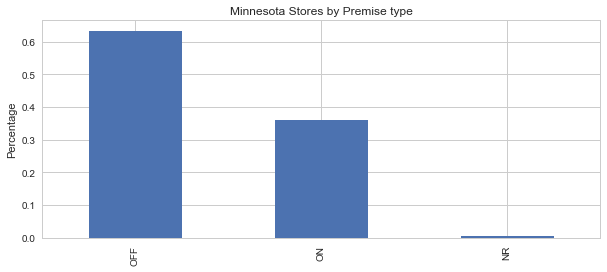

In [6]:
# Minnesota Stores by Premise type
premise_type = All_Stores_Minnesota.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Minnesota Stores by Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [7]:
LowPoint = pd.read_csv('MinnesotaLowPointProducts.csv')
LowPointOn = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'ON', :].reset_index(drop = True)
Top5LowPointOn = LowPointOn.head(15)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0            CORONA LT 6PK BT
1     CORONA LIGHT 1/2 BL KEG
2             VICTORIA 6PK BT
3           CORONA LT 12PK BT
4            VICTORIA 12PK BT
5       CORONA EX 3.2 12PK BT
6        CORONA EX 3.2 6PK BT
7     MODELO ESP 3.2 12PK CAN
8           CORONA LT 24PK BT
9           VICTORIA 12PK CAN
10         CORONA LT 12PK CAN
11      MODELO ESP 3.2 6PK BT
12    MODELO CHELADA 24OZ CAN
13    MODELO ESP 3.2 24OZ CAN
14    CORONA LIGHT 1/4 BL KEG
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [8]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[5,6,7,11,13]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'CORONA EX 6PK BT', 'MODELO ESP 12PK CAN', 'MODELO ESP 6PK BT', 'MODELO ESP 24OZ CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
2,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
3,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
4,MODELO ESP 3.2 24OZ CAN,MODELO ESP 24OZ CAN


In [9]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 12PK BT',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 24OZ CAN',
 'CORONA EX 12PK BT',
 'CORONA EX 6PK BT',
 'MODELO ESP 12PK CAN',
 'MODELO ESP 6PK BT',
 'MODELO ESP 24OZ CAN']

### Analysis for On-Premise

In [10]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Minnesota.loc[All_Stores_Minnesota['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,102798460,CORONA EX 6PK BT,DINING,POLISHED CASUAL,ON,3.0
1,105524853,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,22.0
2,105646726,CORONA EX 6PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,16.0
3,305645361,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,1.0
4,101732739,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,2.0


In [11]:
len(Top5_On_pairs_stores)

5291

In [12]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT',
       'CORONA EX 3.2 12PK BT', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 12PK CAN', 'MODELO ESP 3.2 12PK CAN',
       'MODELO ESP 3.2 24OZ CAN', 'MODELO ESP 3.2 6PK BT',
       'MODELO ESP 24OZ CAN'], dtype=object)

In [13]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']        

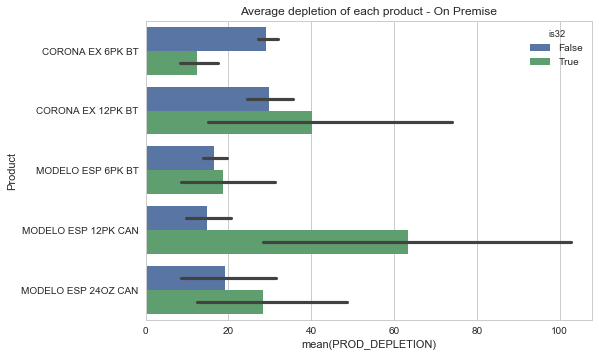

In [14]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product - On Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

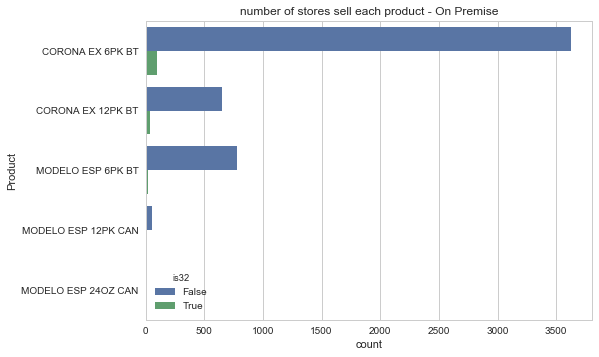

In [15]:
#plot number of stores sell each product for On-premise
plt.title("number of stores sell each product - On Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

In [16]:
len(graph_DF.loc[graph_DF['Product'] == 'MODELO ESP 24OZ CAN', :])

19

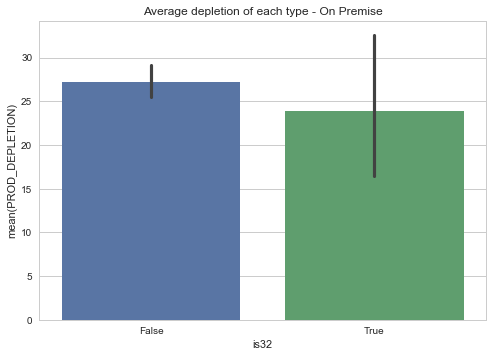

In [17]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

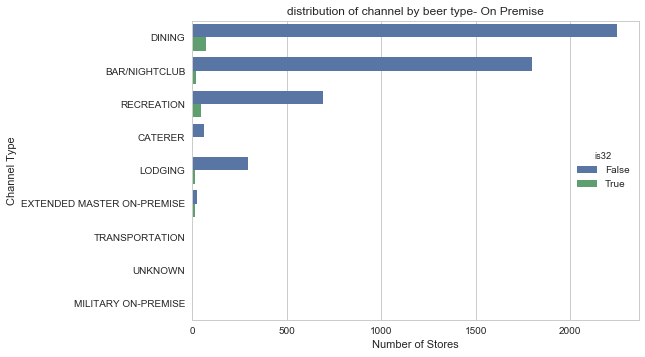

In [18]:
#plot distribution of channel by beer type for On-premise
plt.title("distribution of channel by beer type- On Premise")
graph = sns.countplot(y='RTL_CHANNEL_DSC', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Channel Type');

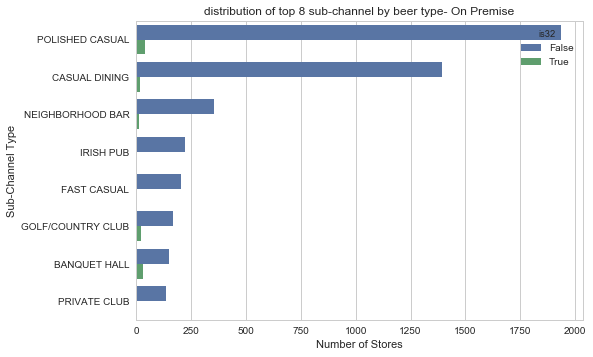

In [19]:
#plot distribution of Sub-channel by beer type for On-premise
plt.title("distribution of top 8 sub-channel by beer type- On Premise")
graph = sns.countplot(y='RTL_SUBCHANNEL_DSC', hue="is32", data=graph_DF, order=graph_DF.RTL_SUBCHANNEL_DSC.value_counts().iloc[:8].index)
graph.set_yticklabels(graph_DF['RTL_SUBCHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Sub-Channel Type');

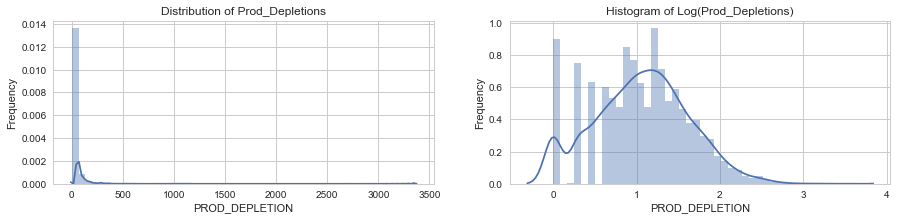

In [20]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

In [21]:
#pair1:
subset1 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
subset1.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,105649123,CORONA EX 12PK BT,BAR/NIGHTCLUB,IRISH PUB,ON,13.0,CORONA EX 12PK BT,False
1,105646783,CORONA EX 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,3.0,CORONA EX 12PK BT,False
2,107236571,CORONA EX 12PK BT,CATERER,BANQUET HALL,ON,3.0,CORONA EX 12PK BT,False
3,205645492,CORONA EX 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,16.0,CORONA EX 12PK BT,False
4,105648294,CORONA EX 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,3.0,CORONA EX 12PK BT,False


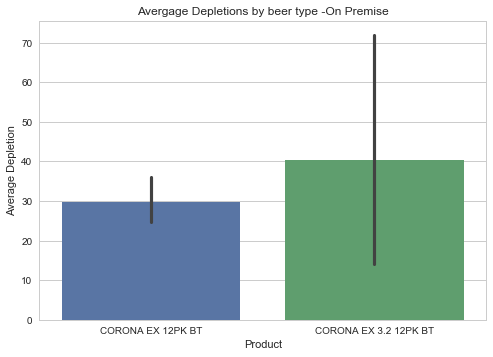

In [22]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

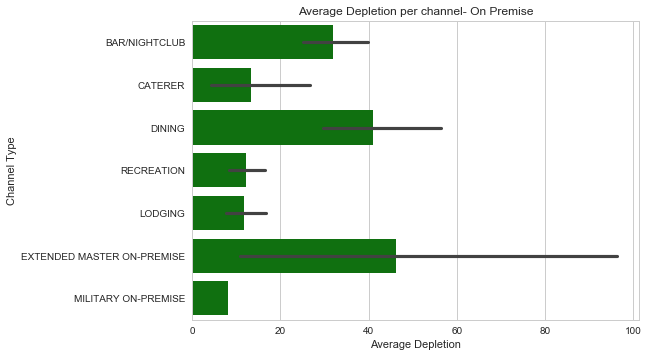

In [23]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset1, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

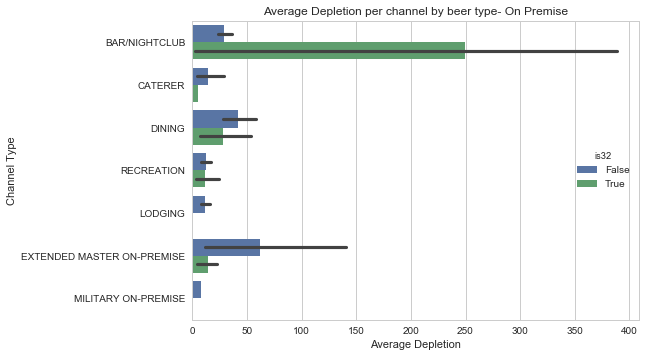

In [24]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset1)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [25]:
#pair1: 
Regression_ON_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset1)
print(Regression_ON_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.042
Model:                                OLS   Adj. R-squared:                  0.033
Method:                     Least Squares   F-statistic:                     4.284
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           0.000120
Time:                            13:58:31   Log-Likelihood:                -1233.7
No. Observations:                     685   AIC:                             2483.
Df Residuals:                         677   BIC:                             2520.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### Pair 2:  

In [26]:
#pair 2:
subset2 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)

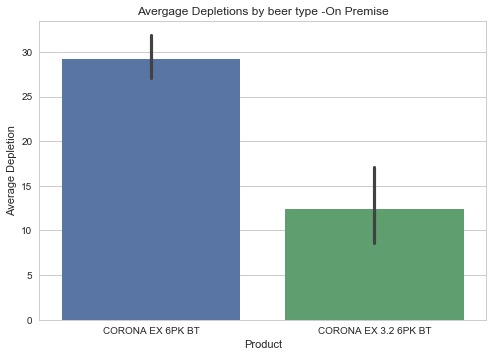

In [27]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

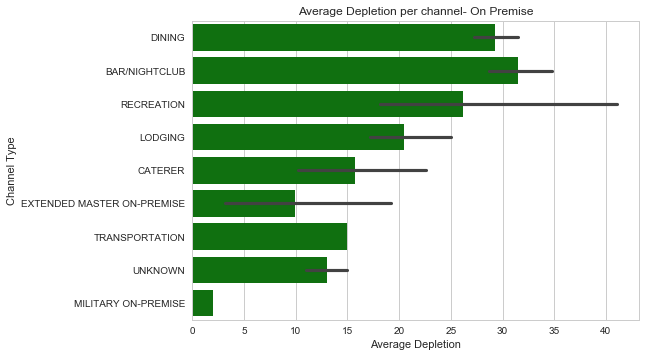

In [28]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset2, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

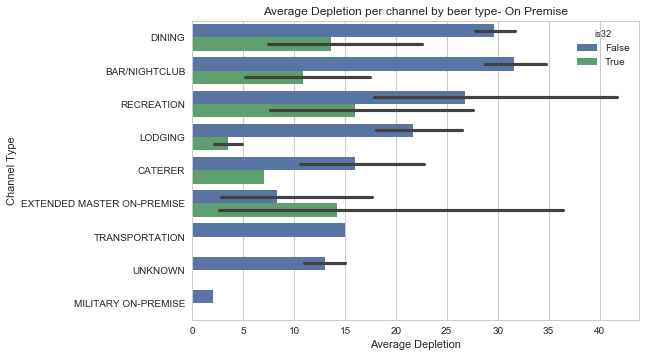

In [29]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset2)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [30]:
#pair 2: 
Regression_ON_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset2)
print(Regression_ON_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.039
Model:                                OLS   Adj. R-squared:                  0.036
Method:                     Least Squares   F-statistic:                     16.64
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           3.79e-27
Time:                            13:58:33   Log-Likelihood:                -5909.0
No. Observations:                    3719   AIC:                         1.184e+04
Df Residuals:                        3709   BIC:                         1.190e+04
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### Pair 3: 

In [31]:
#pair 3:
subset3 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)

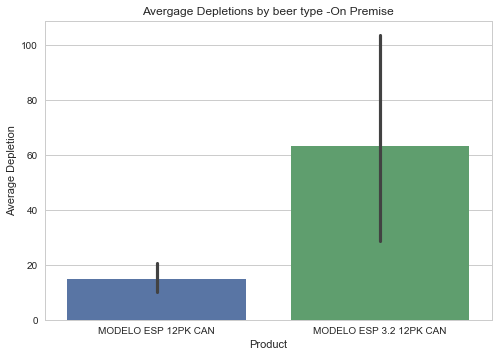

In [32]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

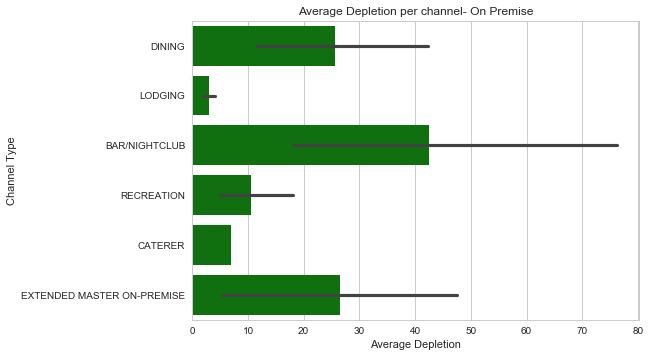

In [33]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset3, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

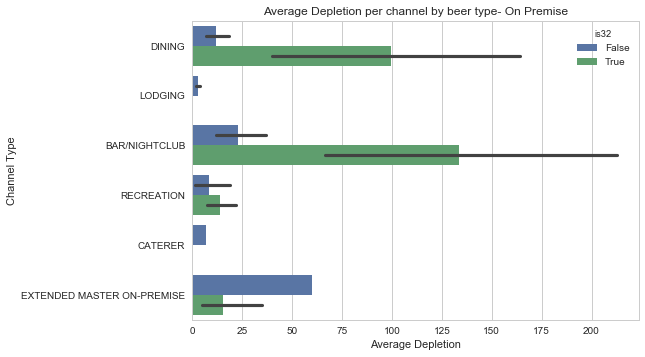

In [34]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset3)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [35]:
#pair 3: 
Regression_ON_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset3)
print(Regression_ON_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.252
Model:                                OLS   Adj. R-squared:                  0.179
Method:                     Least Squares   F-statistic:                     3.432
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):            0.00552
Time:                            13:58:34   Log-Likelihood:                -112.66
No. Observations:                      68   AIC:                             239.3
Df Residuals:                          61   BIC:                             254.9
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### pair 4  

In [36]:
#pair 4 
subset4 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)

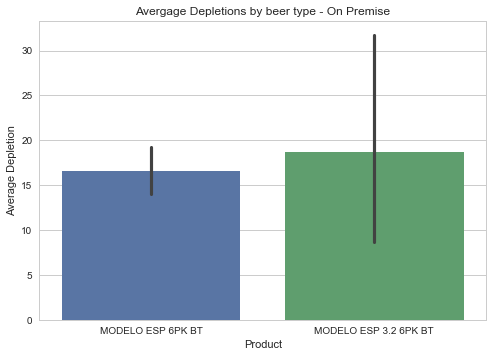

In [37]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

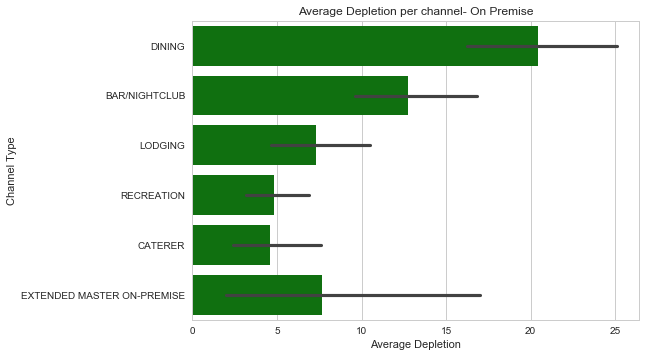

In [38]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset4, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

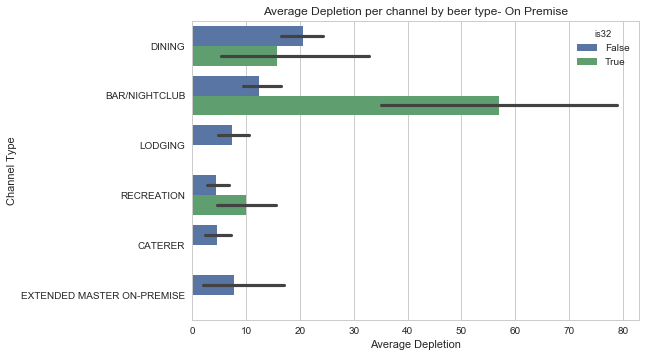

In [39]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset4)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [40]:
#pair 4  
Regression_ON_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset4)
print(Regression_ON_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.052
Method:                     Least Squares   F-statistic:                     8.292
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           9.94e-09
Time:                            13:58:36   Log-Likelihood:                -1332.9
No. Observations:                     800   AIC:                             2680.
Df Residuals:                         793   BIC:                             2713.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### pair 5 

In [41]:
#pair 5 
subset5 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)

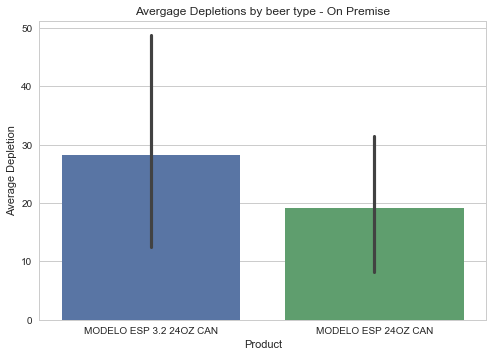

In [42]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');

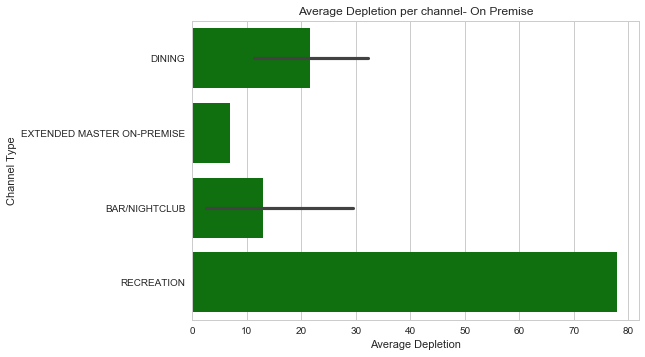

In [43]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset5, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

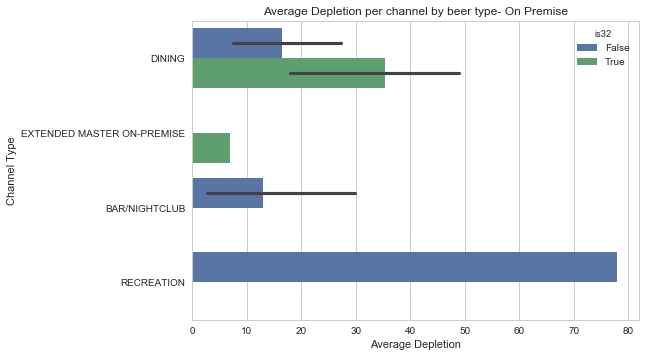

In [44]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset5)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [45]:
#pair 5
Regression_ON_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset5)
print(Regression_ON_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.286
Model:                                OLS   Adj. R-squared:                  0.082
Method:                     Least Squares   F-statistic:                     1.402
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.284
Time:                            13:58:37   Log-Likelihood:                -30.469
No. Observations:                      19   AIC:                             70.94
Df Residuals:                          14   BIC:                             75.66
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

C:\Users\anugratama\AppData\Local\Continuum\Anaconda3\lib\site-packages\scipy\stats\stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


### Load Product Data for Off-Premise

In [46]:
#load the product data for Off Premise 
LowPointOff = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'OFF', :].reset_index(drop = True)
Top5LowPointOff = LowPointOff.head(15)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0           CORONA LT 12PK BT
1       CORONA EX 3.2 12PK BT
2            VICTORIA 12PK BT
3     MODELO ESP 3.2 12PK CAN
4           CORONA LT 24PK BT
5            CORONA LT 6PK BT
6        CORONA EX 3.2 6PK BT
7     MODELO CHELADA 24OZ CAN
8          CORONA LT 12PK CAN
9           CORONA LT 18PK BT
10            VICTORIA 6PK BT
11      MODELO ESP 3.2 6PK BT
12     MODELO ESP 3.2 12PK BT
13          VICTORIA 12PK CAN
14      CORONA EX 3.2 24OZ BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [47]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[1,3,6,11,12]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'MODELO ESP 12PK CAN','CORONA EX 6PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
2,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
3,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
4,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT


In [48]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 6PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 6PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT']

### Analysis for Off-Premise

In [49]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Minnesota.loc[All_Stores_Minnesota['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,103923027,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
1,100187799,MODELO ESP 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,46.0
2,200763598,MODELO ESP 12PK CAN,LIQUOR,CONVENTIONAL LIQUOR,OFF,30.0
3,100702391,CORONA EX 3.2 12PK BT,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OFF,13.0
4,101425627,CORONA EX 6PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,4.0


In [50]:
len(Top5_Off_pairs_stores)

6277

In [51]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 6PK BT', 'MODELO ESP 12PK CAN', 'CORONA EX 3.2 12PK BT',
       'CORONA EX 6PK BT', 'MODELO ESP 12PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK CAN', 'CORONA EX 3.2 6PK BT',
       'MODELO ESP 3.2 6PK BT', 'MODELO ESP 3.2 12PK BT'], dtype=object)

In [52]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']  

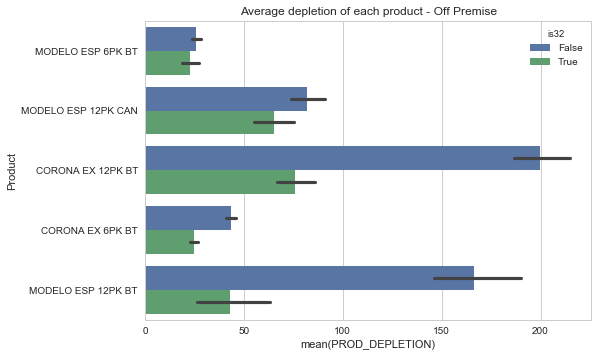

In [53]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

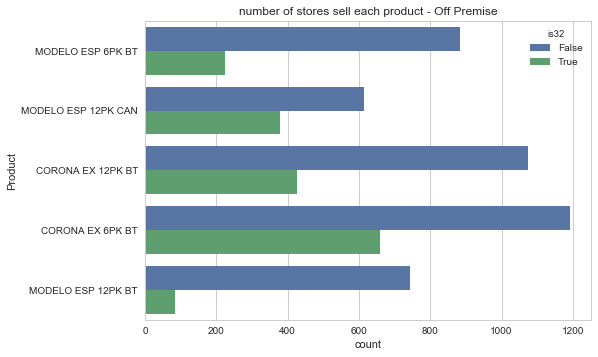

In [54]:
#plot number of stores sell each product for Off-premise
plt.title("number of stores sell each product - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0);

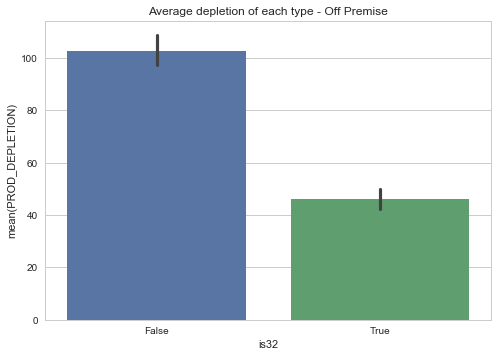

In [55]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF);

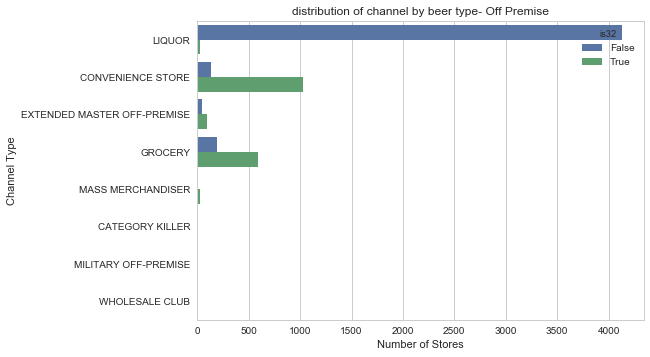

In [56]:
#plot distribution of channel by beer type for Off-premise
plt.title("distribution of channel by beer type- Off Premise")
graph = sns.countplot(y='RTL_CHANNEL_DSC', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Channel Type');

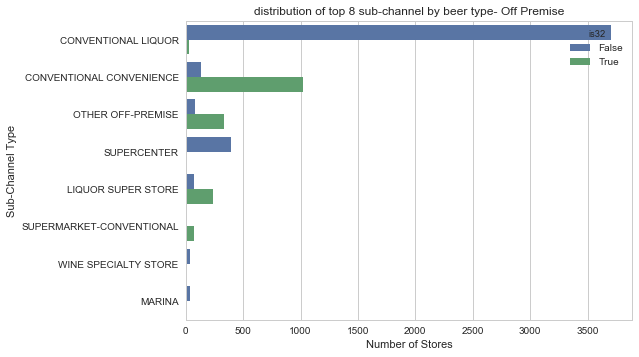

In [57]:
#plot distribution of Sub-channel by beer type for Off-premise
plt.title("distribution of top 8 sub-channel by beer type- Off Premise")
graph = sns.countplot(y='RTL_SUBCHANNEL_DSC', hue="is32", data=graph_DF, order=graph_DF.RTL_SUBCHANNEL_DSC.value_counts().iloc[:8].index)
graph.set_yticklabels(graph_DF['RTL_SUBCHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Sub-Channel Type');

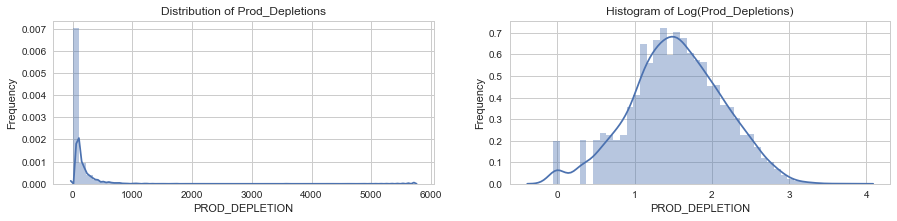

In [58]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');


## Regression Analysis on Five products for Off-premise

### Pair 1

In [59]:
subset1 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)

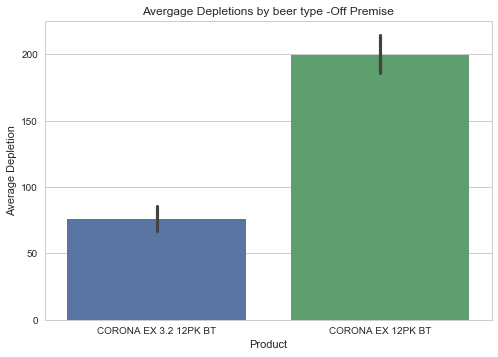

In [60]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

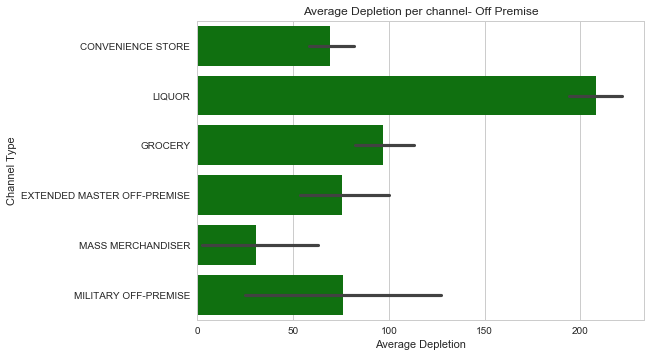

In [61]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset1, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

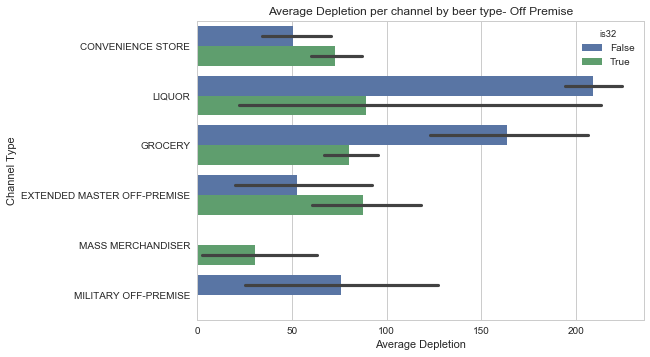

In [62]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset1)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [63]:
Regression_Off_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset1)
print(Regression_Off_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.168
Model:                                OLS   Adj. R-squared:                  0.165
Method:                     Least Squares   F-statistic:                     50.21
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.08e-56
Time:                            13:58:44   Log-Likelihood:                -2368.6
No. Observations:                    1500   AIC:                             4751.
Df Residuals:                        1493   BIC:                             4788.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### pair2

In [64]:
subset2 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)

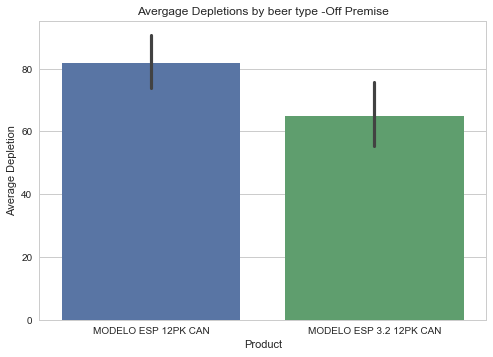

In [65]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

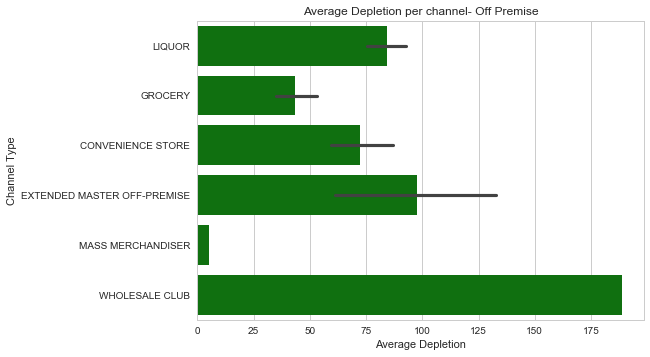

In [66]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset2, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

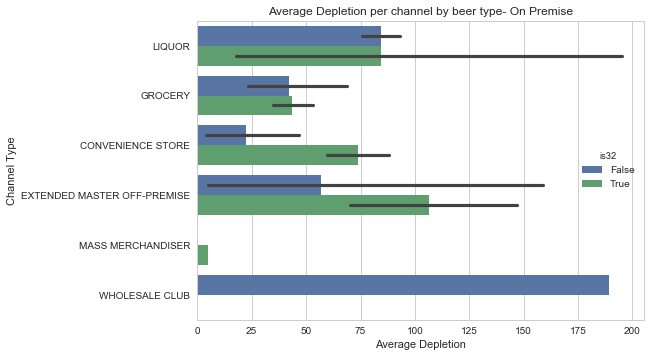

In [67]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset2)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [68]:
Regression_Off_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset2)
print(Regression_Off_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.049
Model:                                OLS   Adj. R-squared:                  0.043
Method:                     Least Squares   F-statistic:                     8.440
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           5.97e-09
Time:                            13:58:45   Log-Likelihood:                -1652.2
No. Observations:                     991   AIC:                             3318.
Df Residuals:                         984   BIC:                             3353.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### pair3

In [69]:
#pair3:
subset3 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)

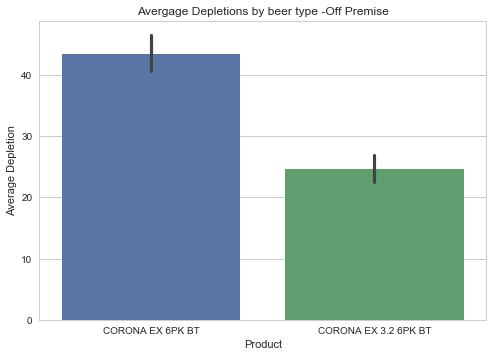

In [70]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

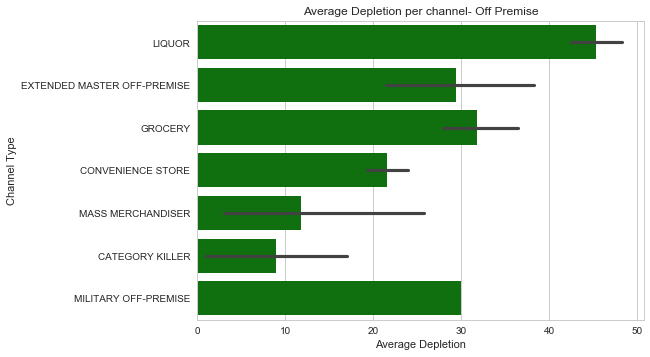

In [71]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset3, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

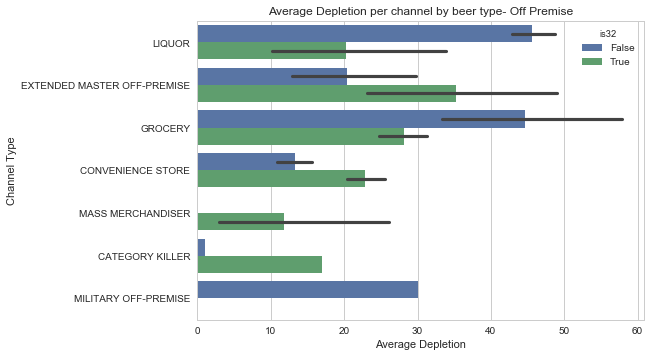

In [72]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset3)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [73]:
Regression_Off_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset3)
print(Regression_Off_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.064
Model:                                OLS   Adj. R-squared:                  0.063
Method:                     Least Squares   F-statistic:                     126.3
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           2.18e-28
Time:                            13:58:47   Log-Likelihood:                -2674.5
No. Observations:                    1852   AIC:                             5353.
Df Residuals:                        1850   BIC:                             5364.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

### Pair 4

In [74]:
subset4 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)

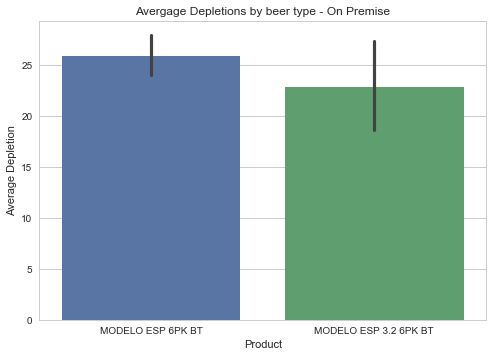

In [75]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

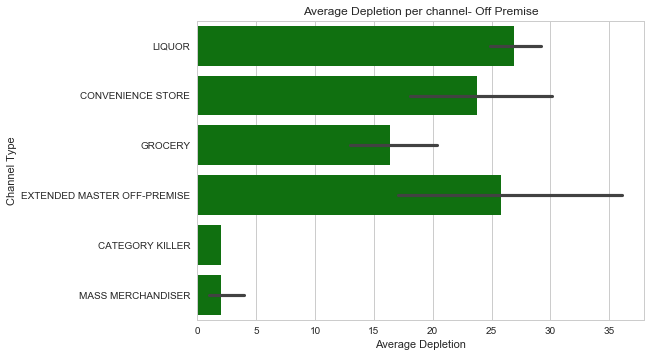

In [76]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset4, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

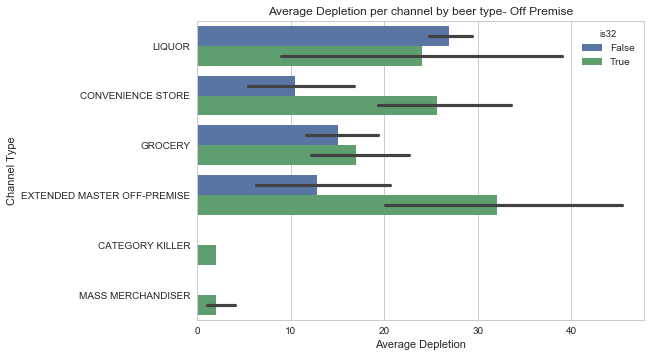

In [77]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset4)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [78]:
Regression_Off_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset4)
print(Regression_Off_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.045
Model:                                OLS   Adj. R-squared:                  0.039
Method:                     Least Squares   F-statistic:                     8.560
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           4.11e-09
Time:                            13:58:49   Log-Likelihood:                -1649.4
No. Observations:                    1107   AIC:                             3313.
Df Residuals:                        1100   BIC:                             3348.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Pair 5 

In [79]:
subset5 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)

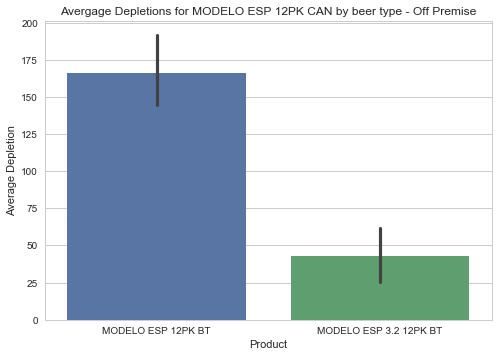

In [80]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions for MODELO ESP 12PK CAN by beer type - Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');

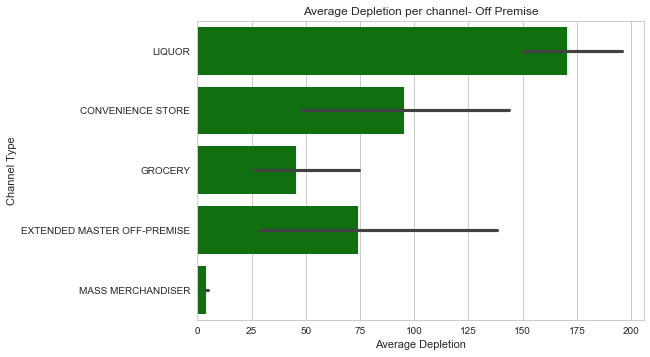

In [81]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset5, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

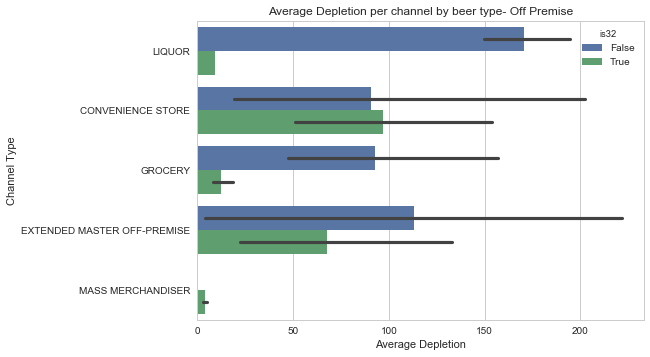

In [82]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset5)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [83]:
Regression_Off_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset5)
print(Regression_Off_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.158
Model:                                OLS   Adj. R-squared:                  0.153
Method:                     Least Squares   F-statistic:                     30.73
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           1.05e-28
Time:                            13:58:51   Log-Likelihood:                -1439.3
No. Observations:                     827   AIC:                             2891.
Df Residuals:                         821   BIC:                             2919.
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------